Based on a post @ [Towards Data Science](https://towardsdatascience.com/analyzing-yelp-dataset-with-scattertext-spacy-82ea8bb7a60e).

# Analyzing Yelp Dataset with Scattertext spaCy

"This post will explore the [Yelp Dataset](https://www.yelp.com/dataset/challenge) then use [Scattertext](https://spacy.io/universe/project/scattertext) to visualize and analyze the text data".

### What is Scattertext?

"[Scattertext](https://github.com/JasonKessler/scattertext) is a tool that’s intended for visualizing what words and phrases are more characteristic of a category than others".

### Data Source

"For this example, we will be focusing on RV related categories in the Yelp dataset".
- "The [full Yelp dataset](https://www.yelp.com/dataset/challenge) consists of over 1000 categories and 6 million reviews".
- "Our edited CSV file can be found in my [GitHub repo](https://github.com/gyhou/yelp_dataset/blob/master/yelp_reviews_RV_categories.csv) along with the Jupyter Notebook of how I convert the Yelp dataset JSON files into a CSV file".
- "A [medium article](https://link.medium.com/0k0DEb3Qy1) was also posted to give a more thorough explanation of the conversion process".

- "This edited csv consists of 5 categories from the Yelp dataset: `RV Repair`, `RV Dealers`, `RV Rental`, `RV Parks`, `Campgrounds`".

### Load and Clean the dataset


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('./yelp_reviews_RV_categories.csv')

"Before we begin, we want to figure out how to group the ratings".
- "By using `seaborn` [`distplot`](https://seaborn.pydata.org/generated/seaborn.distplot.html) we can check how the rating is distributed in this dataset".

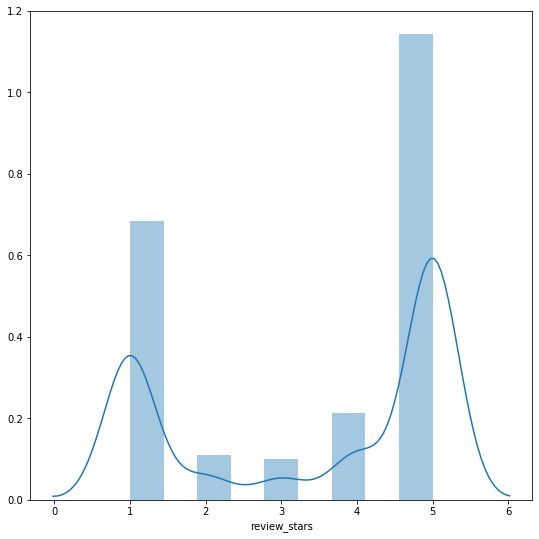

In [3]:
fig, ax = plt.subplots(figsize=(9,9))

sns.distplot(df['review_stars'], ax=ax)

plt.show()

"This plot shows most reviews are rated 1 or 5 stars, while we could only compare reviews between 5 stars and 1 star, that would leave out the reviews from 2–4 stars".
- "Instead, let’s consolidate the ratings to either high or low".


In [4]:
df['rating'] = df['review_stars'].replace({1:'Low Rating', 2:'Low Rating',
                                           3:'Low Rating',4:'High Rating',
                                           5:'High Rating'})

"Since we know this dataset has 5 different categories, we can further group similar categories together".
- "Let’s work with only the `RV parks` and `Campgrounds`, leaving out `RV Repair`, `RV Dealers`, and `RV Rental` for now".

In [5]:
df_Parks_Camp = df[df['categories'].str.contains('RV Parks|Campgrounds', na=False)]

### NLP analysis — using Scattertext & spaCy

"Now that we have our dataset preprocessed, we can begin some analysis".
- "Make sure you have a [spaCy English model](https://spacy.io/models/en) downloaded in your kernel".

> "`en_core_web_sm` is a small [English model](https://spacy.io/models#conventions) trained on written web text (blogs, news, comments), that includes vocabulary, vectors, syntax and entities".


To install `spaCy`, see [this link](https://spacy.io/usage).

To install `scattertext`, see [this link](https://anaconda.org/conda-forge/scattertext).

To *uninstall* a `spaCy` model, see [this link](https://stackoverflow.com/questions/53052868/dont-know-how-to-uninstall-unwanted-spacy-installation-model).

In [6]:
import spacy
import scattertext

In [7]:
# !python -m spacy download en_core_web_sm

In [8]:
nlp = spacy.load('en_core_web_sm')

"Next, we will use the function below to":

- "Set up our corpus, a collection of texts from the dataset";
- "Get term frequency and [scaled f-score](https://github.com/JasonKessler/scattertext#understanding-scaled-f-score)";
- "Create data frames in descending order for `High Rating` & `Low Rating`".


In [9]:
def term_freq(df_yelp):
    corpus = (scattertext.CorpusFromPandas(df_yelp, category_col='rating', text_col='text',
                                           nlp=nlp).build().remove_terms(nlp.Defaults.stop_words, ignore_absences=True))

    df = corpus.get_term_freq_df()
    df['High_Rating_Score'] = corpus.get_scaled_f_scores('High Rating')
    df['Low_Rating_Score'] = corpus.get_scaled_f_scores('Low Rating')
    df['High_Rating_Score'] = round(df['High_Rating_Score'], 2)
    df['Low_Rating_Score'] = round(df['Low_Rating_Score'], 2)
    
    df_high = df.sort_values(by='High Rating freq', 
                             ascending = False).reset_index()
    df_low = df.sort_values(by='Low Rating freq', 
                            ascending=False).reset_index()

    return df_high, df_low

In [10]:
Parks_Camp_high, Parks_Camp_low = term_freq(df_Parks_Camp)

In [11]:
Parks_Camp_high.head(10)

,term,High Rating freq,Low Rating freq,High_Rating_Score,Low_Rating_Score
0,park,583,466,0.90,0.10
1,rv,569,408,0.91,0.09
2,great,551,88,0.98,0.02
3,nice,483,196,0.95,0.05
4,clean,417,134,0.96,0.04
5,in the,407,475,0.14,0.86
6,place,396,322,0.90,0.10
7,stay,322,248,0.90,0.10
8,of the,315,343,0.86,0.14
9,friendly,295,83,0.97,0.03


In [12]:
Parks_Camp_low.head(10)

,term,High Rating freq,Low Rating freq,High_Rating_Score,Low_Rating_Score
0,in the,407,475,0.14,0.86
1,park,583,466,0.90,0.10
2,rv,569,408,0.91,0.09
3,of the,315,343,0.86,0.14
4,place,396,322,0.90,0.10
5,to the,249,275,0.86,0.14
6,like,197,268,0.12,0.88
7,time,263,263,0.87,0.13
8,it was,203,262,0.13,0.87
9,room,159,260,0.10,0.90


## Understanding the Scoring System

"`scattertext` uses scaled f-score, which takes into account the category-specific precision and term frequency".
- "While a term may appear frequently in both categories (`High` and `Low` rating), the scaled f-score determines whether the term is more characteristic of a category than others (`High` or `Low` rating)".
- "For example, while the term 'park' is frequent in both `High` and `Low` rating, the scaled f-score concludes 'park' is more associated with `High`($0.90$) than `Low` ($0.10$) rating".

## Stop words

"Notice how some terms are not expected in the list, such as 'in the', 'of the', 'to the', 'it was', these are some examples of stop words that can be removed".

"While doing NLP, [stop words](https://en.wikipedia.org/wiki/Stop_words) are some extremely common words that would appear to be of little value in helping select documents are excluded from the vocabulary entirely such as 'the', 'them' and 'they'".

Therefore: `.remove_terms(nlp.Defaults.stop_words, ignore_absences=True))`.

"`spaCy` has 326 default stop words which we have removed from the corpus using the code above but we can add more".

"We can add more stop words from the [Natural Language Toolkit](https://www.nltk.org/) (NLTK)".

~~~
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))
nlp.Defaults.stop_words |= stopWords
~~~

"We can also set up our own stop words by creating a `stopwords.txt` file".
- "Write anything (including symbols, numbers, terms) inside the text file as stop words to be **removed** from the corpus".
- "Feel free to use the stopwords.txt file inside my [GitHub repo](https://github.com/gyhou/yelp_dataset/blob/master/stopwords.txt)".

In [21]:
with open('stopwords.txt', 'r') as f:
    str_f = f.read()
    set_stopwords = set(str_f.split('\n'))

nlp.Defaults.stop_words |= set_stopwords # Equivalent to .union()

"Whenever we're done updating the text file, remember to save so it updates into the original set of stop words by running the code above".

"Once more stop words are added, we can run the `term_freq` function again".


In [22]:
Parks_Camp_high, Parks_Camp_low = term_freq(df_Parks_Camp)

In [23]:
Parks_Camp_high.head(10)

,term,High Rating freq,Low Rating freq,High_Rating_Score,Low_Rating_Score
0,park,583,466,0.90,0.10
1,great,551,88,0.98,0.02
2,nice,483,196,0.95,0.05
3,clean,417,134,0.96,0.04
4,stay,322,248,0.90,0.10
5,friendly,295,83,0.97,0.03
6,pool,270,128,0.94,0.06
7,time,263,263,0.87,0.13
8,staff,251,150,0.92,0.08
9,area,249,124,0.94,0.06


In [24]:
Parks_Camp_low.head(10)

,term,High Rating freq,Low Rating freq,High_Rating_Score,Low_Rating_Score
0,park,583,466,0.90,0.10
1,time,263,263,0.87,0.13
2,room,159,260,0.10,0.90
3,service,181,256,0.12,0.88
4,stay,322,248,0.90,0.10
5,$,93,209,0.07,0.93
6,people,154,207,0.12,0.88
7,nice,483,196,0.95,0.05
8,night,124,177,0.12,0.88
9,good,231,174,0.90,0.10


### Scattertext Visualization

"We can create a scatter plot to visualize the term associations between high and low ratings of the reviews from the Yelp dataset".

[**Interactive HTML**](https://gyhou.com/RV-Parks-Campgrounds-Yelp-Reviews-Scattertext.html)

In [29]:
# This next line is missing in the example!
corpus = (scattertext.CorpusFromPandas(df, category_col='rating', text_col='text',
                                       nlp=nlp).build().remove_terms(nlp.Defaults.stop_words, ignore_absences=True))

corpus_dataframe = df

html = scattertext.produce_scattertext_explorer(
                   corpus,
                   category='Low Rating',
                   category_name='Low Rating',
                   not_category_name='High Rating',
                   width_in_pixels=1000,
                   metadata=corpus_dataframe['name'])

C:\Users\BigData\AppData\Local\Continuum\anaconda3\lib\site-packages\scattertext\TermDocMatrix.py:890: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  corpus_unigram_freq = corpus_freq_df.ix[[term for term


In [34]:
# from IPython.core.display import display, HTML
# display(HTML(html))

### Understanding Scattertext plot

"On the right side of the scatter plot, we have an overview of top rated terms and an unordered list of terms under characteristic".
- "If we click on the term, it will show us the specific reviews that were inside the dataset, indicating as Low or High rating. We can also manually search for a term on the bottom left-hand side".

"From the scatter plot, we get a quick glance at the terms used in the reviews".
- "The red dots on the right side of the plot indicate terms that are more associated with aHigh rating while blue dots on the left side indicate terms that are more associated with a Low rating".

"With this Scattertext plot, we can easily search for terms that may be useful for Yelp businesses".
- "Not only can we see if a term is more closely associated with a positive or negative rating, but we can also read each individual review".

### Save and share as an HTML file


In [33]:
html_file_name = "RV-Parks-Campgrounds-Yelp-Review-Scattertext.html"
open(html_file_name, 'wb').write(html.encode('utf-8'))

5573517